# Oppgave 1

Innledning goes here

In [64]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



Oppgave 1a)

In [65]:
#Oppgave 1a)
#Defining params

A = 0.1
epsilon = 0.25
omega = 1

In [66]:
# Defining given functions

def a(t):
    return epsilon * np.sin(omega * t)

def b(t):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x, t):
    return a(t) * x**2 + b(t) * x

def fDelX(x, t):
    return 2 * a(t) * x + b(t)

def vX(x, y, t):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x, y, t):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)


def coordDerived(coords, t):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

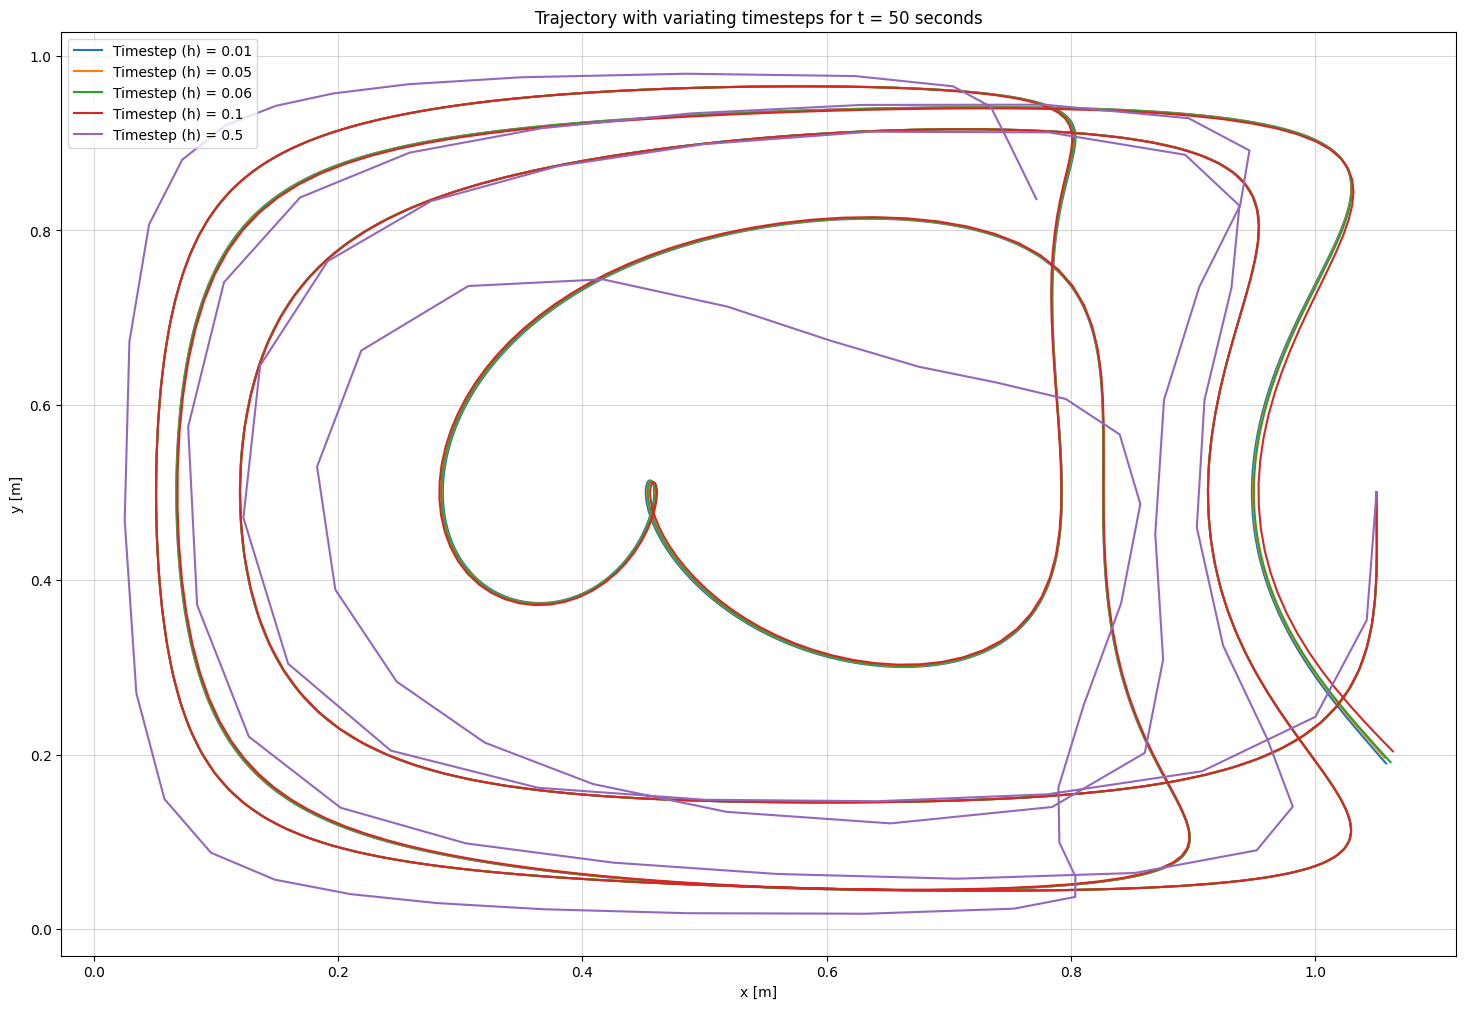

In [67]:
# Giving initial value to the coordinates-array

def Heun(h, tEnd, initPos, f):
    tList = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(tList)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(tList)):
        coordI = coordArr[:,:,i-1]
        ti = tList[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = coordI +h/2*(k1 + k2)

    return coordArr


plt.figure(figsize=(18, 12))
plt.title("Trajectory with variating timesteps for t = 50 seconds")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

pos0 = np.zeros((2,1))
pos0[0:,] = 1.05
pos0[1:,] = 0.5

hVals = [0.01, 0.05, 0.06, 0.1, 0.5]

for h in hVals:
     trajectory = Heun(h, 50, pos0, coordDerived)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Timestep (h) = {h}")
     plt.grid(alpha=0.5)
     plt.legend()

Kommenter plottet

What seems like a reasonable timestep?
What happens if you double the time? Is same timestep good?

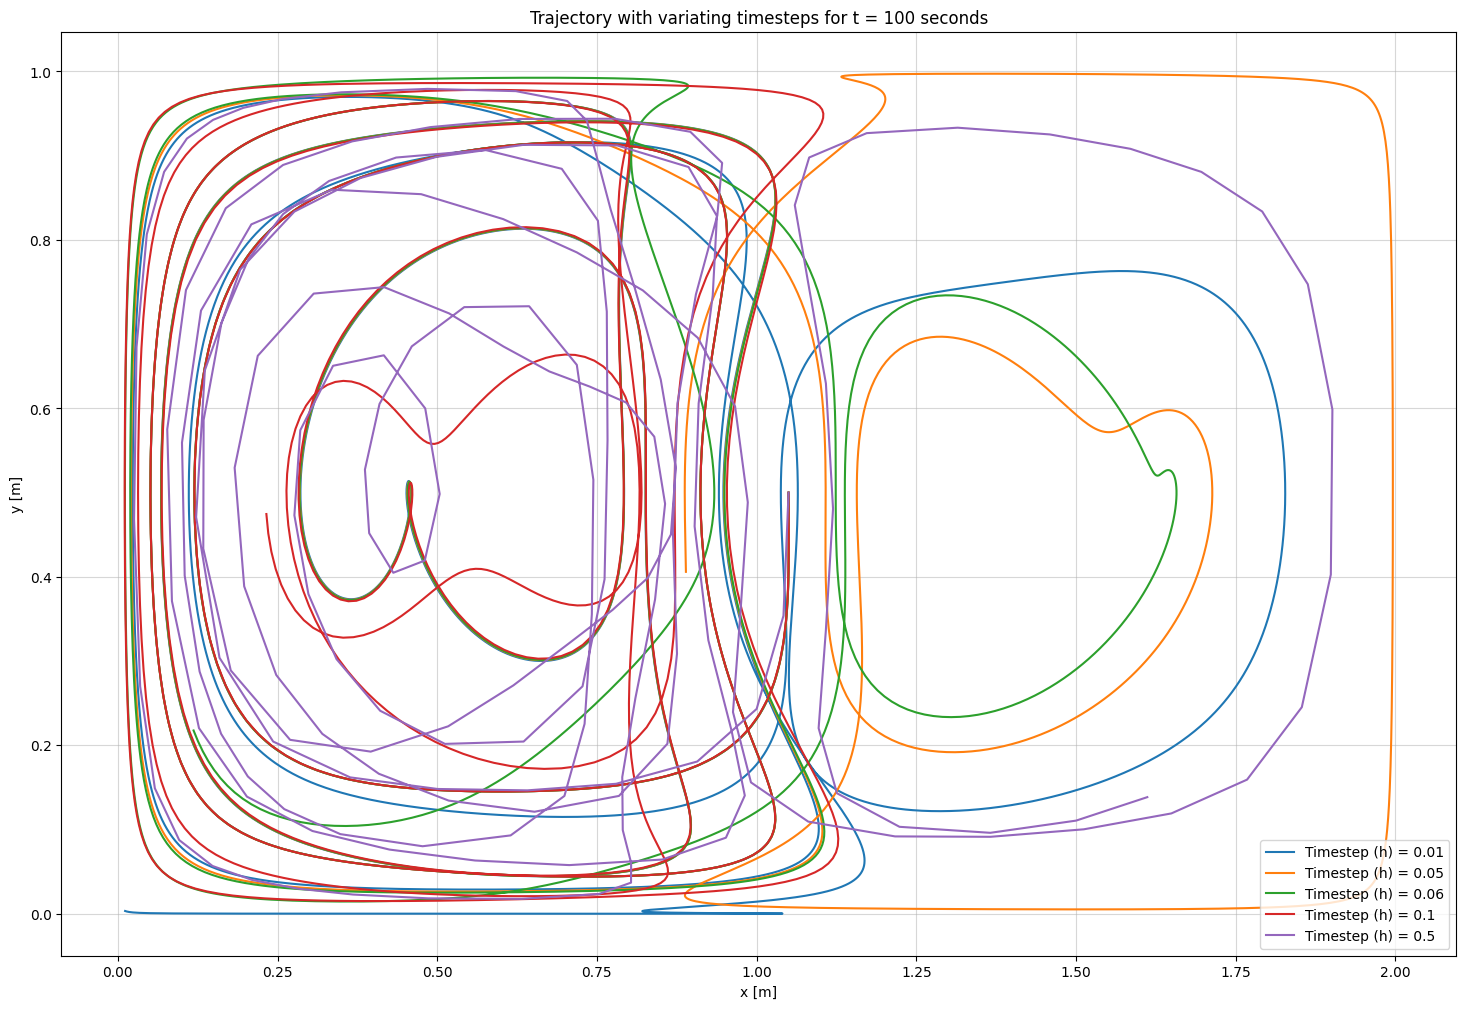

In [68]:
#Double the time?

plt.figure(figsize=(18, 12))
plt.title("Trajectory with variating timesteps for t = 100 seconds")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

for h in hVals:
     trajectory = Heun(h, 100, pos0, coordDerived)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Timestep (h) = {h}")
     plt.grid(alpha=0.5)
     plt.legend()

Kommenter plottet

1b)

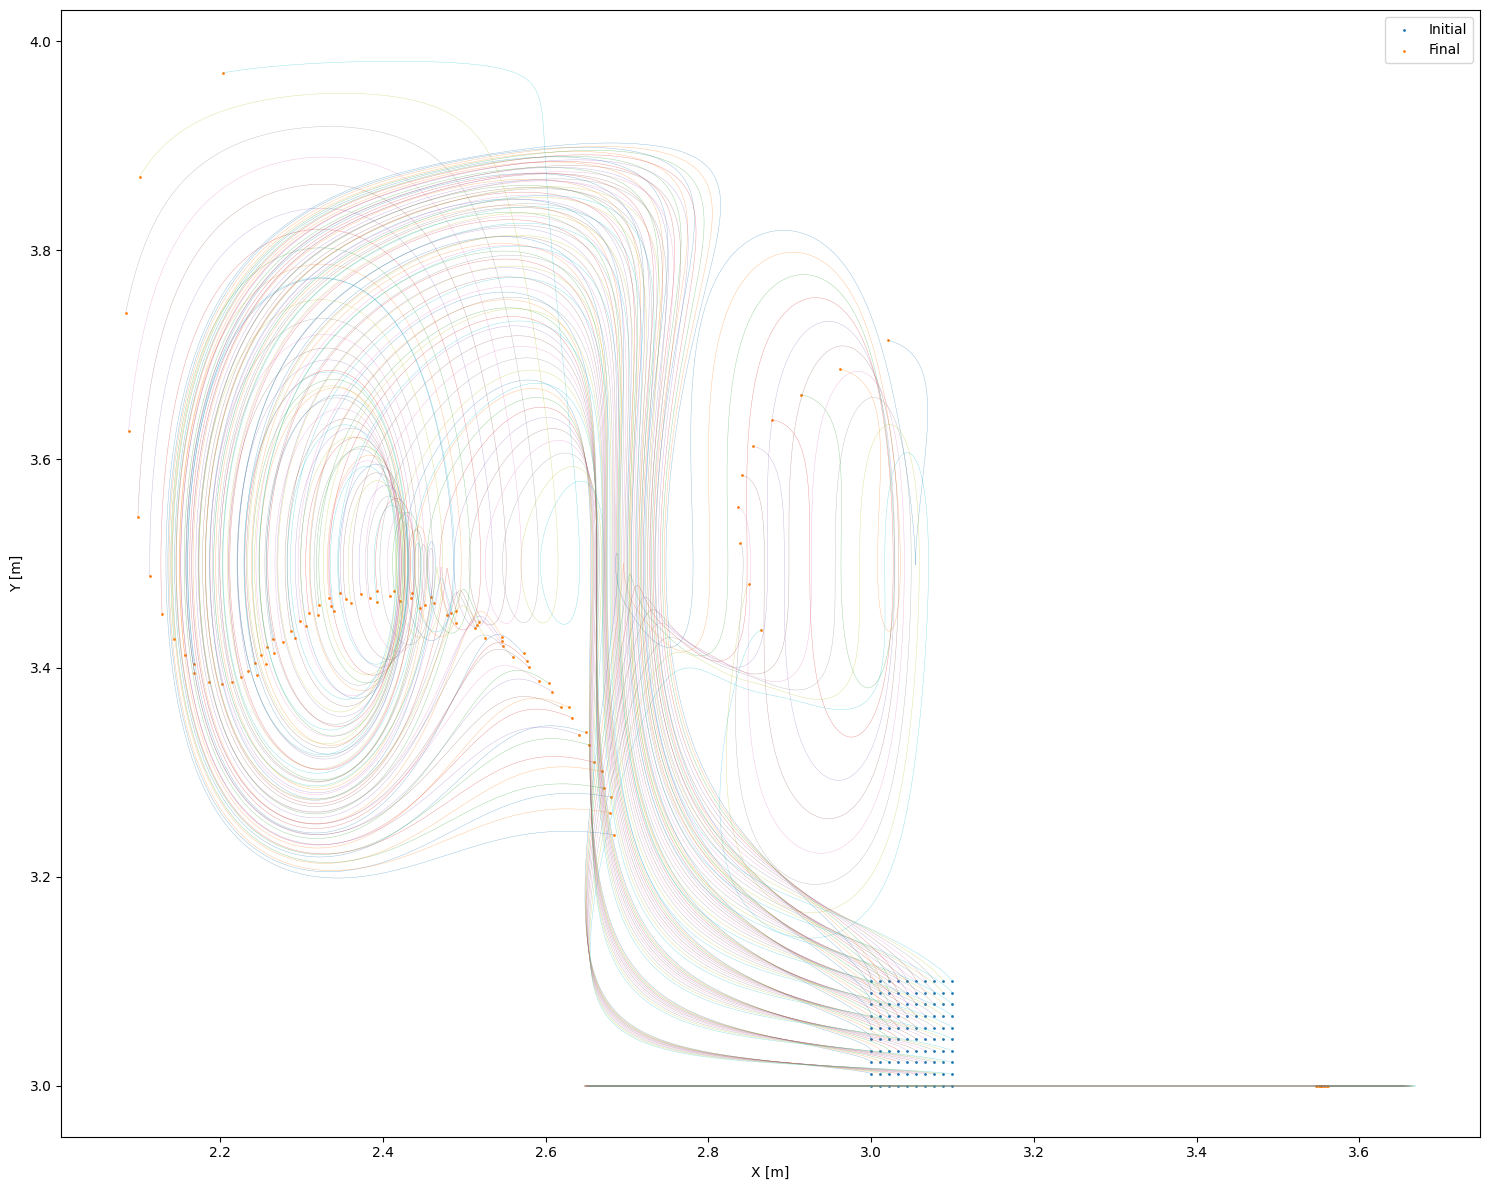

In [69]:
# 100 initial conditions, calculate trajectory for each particle for t \in [0,10]
# In the same plot, show scatters of initial and final pos, as well as trajectories that
# connect.

h_2 = 0.01
Np = 100
rows, columns = int(np.sqrt(Np)), int(np.sqrt(Np))

gridarr = np.linspace(3, 3.1, rows)
X, Y = np.meshgrid(gridarr, gridarr)

initPositions = np.vstack([X.flatten(), Y.flatten()])

B = Heun(h_2, 10, initPositions, coordDerived)

fig = plt.figure(figsize=(15,12))
ax= plt.axes()

ax.scatter(initPositions[0,:], initPositions[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(B[0,i,:],B[1,i,:], lw=0.3, alpha=0.5)
ax.scatter(B[0,:,-1], B[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
plt.tight_layout()

Kommenter plottet

1c)

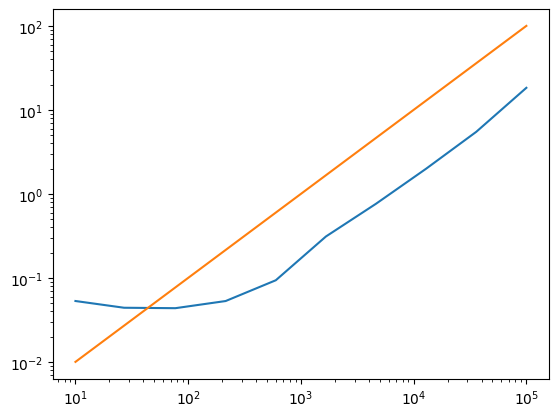

In [70]:
# Test implementation by measuring time to run for different numbers of particles, plot of runtime as function of N_p

N_p_arr = np.logspace(1,5,10, dtype=int)
t_arr = np.zeros(len(N_p_arr))
for i,N_p in enumerate(N_p_arr):
    pos0 = np.zeros((2,N_p))
    pos0[0:,] = np.random.rand(N_p)
    pos0[1:,] = np.random.rand(N_p)

    t0 = time()
    trajectory = Heun(0.01, 10, pos0, coordDerived)
    t1 = time()
    t_arr[i] = t1 - t0

plt.figure()
plt.loglog(N_p_arr, t_arr)
plt.loglog(N_p_arr, N_p_arr/1000)


Looking at the figure above, it seems reasonable that the asymptotic runtime of the implementation is linear. However, when $N_p \in [10^1,10^3]$, the running time seems to be constant. This is because the implementation has some overhead, which dominate for smaller values for $N_p$

2a) Kommenter at dette er utdelt

In [71]:
#2a
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])
    

Tekst om koden under

In [72]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)



# create some positions
mean_x = 790000
mean_y = 490000
standard_dev = 10000

Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = Heun(3600,3600*5*24,X, f)
# scatter plot positions, note the extra transform keyword

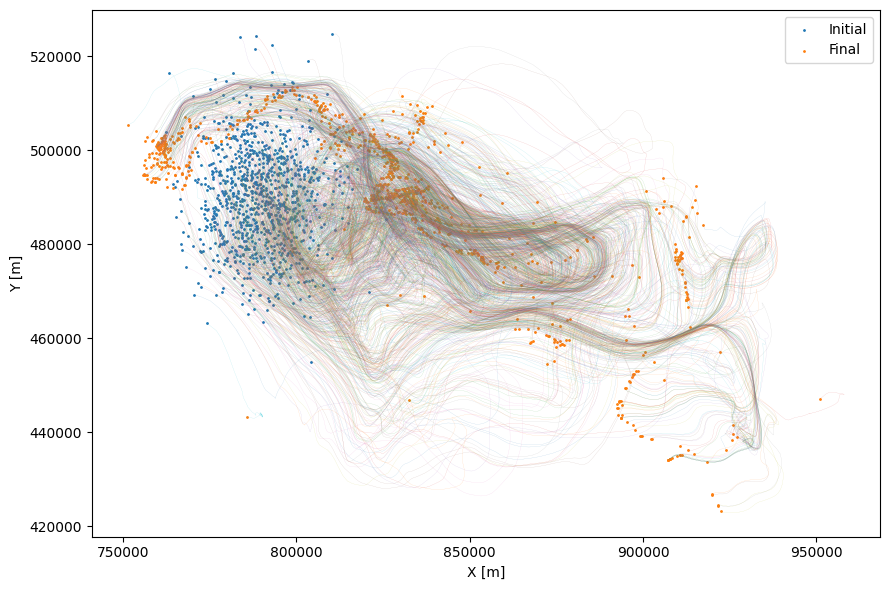

In [73]:
#Plot i xy-planet

fig = plt.figure(figsize=(9,6))
ax= plt.axes()

ax.scatter(X[0,:], X[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
plt.tight_layout()

Kommenter plott

2b)

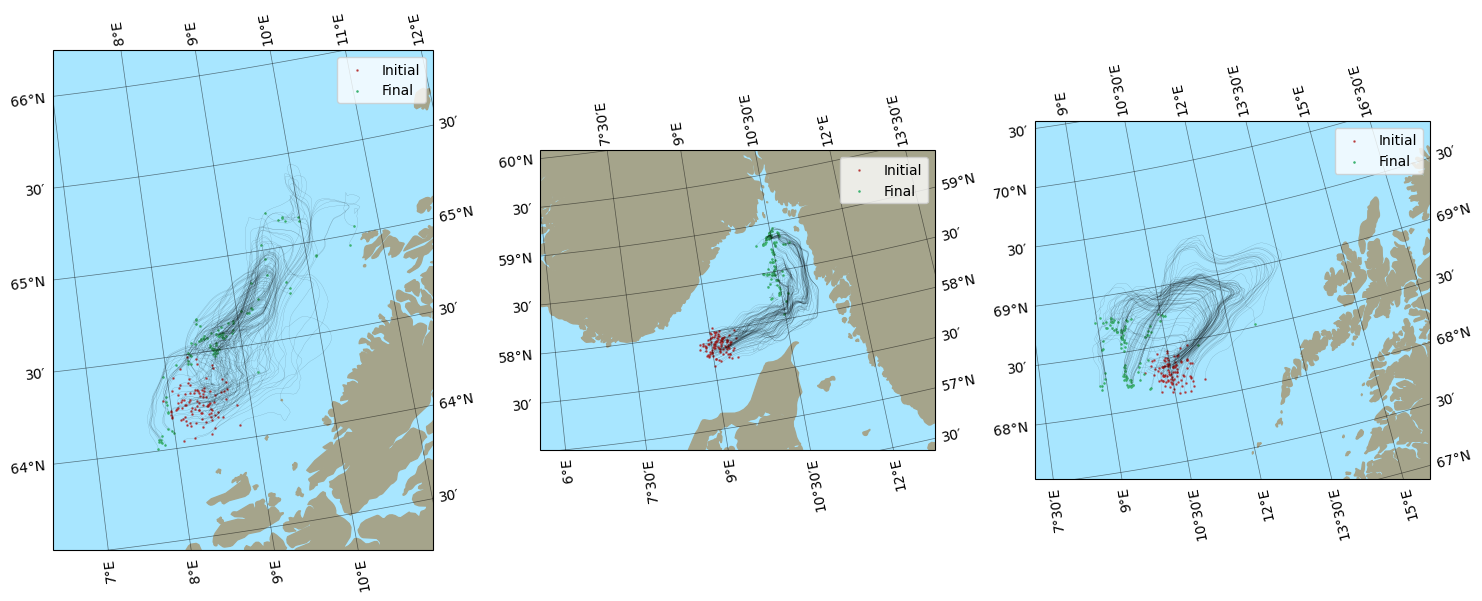

In [79]:
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

args = ((7, 11, 63.5, 66), (6, 13, 59.5, 57), (8, 16, 67.5, 70))
mean_x = np.array([790000, 190000, 1220000])
mean_y = np.array([490000, 110000, 620000])
#S = np.array([X, X1, X2])
#E = np.array([E, E1, E2])

def plottingFunction(args, Np, h, time, standard_dev, mean_x, mean_y, ODE=Heun):
    S = np.zeros((3, 2, Np))
    E = np.zeros((3, 2, Np, time//h))

    for i in range(3):
        S[i, 0, :] = np.random.normal(loc=mean_x[i], scale=standard_dev, size=Np)
        S[i, 1, :] = np.random.normal(loc=mean_y[i], scale=standard_dev, size=Np)
        E[i] = ODE(h, time, S[i,:,:], f)

    num_plots = 3
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

    for ax, args, S_j, E_j in zip(axs, args, S, E):
        s, e, b, t = args
        ax.set_facecolor('#a8e6ff')
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#a5a48b'))
        ax.scatter(S_j[0, :], S_j[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)

        for i in range(Np):
            ax.plot(E_j[0, i,:], E_j[1, i, :], transform=npstere, lw=0.1, alpha=0.5, color='black')
        ax.scatter(E_j[0, :, -1], E_j[1, :, -1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')
        ax.set_extent((s, e, b, t))

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
        ax.legend()

    plt.tight_layout()

plottingFunction(args, 100, 3600, 3600*24*5, 10000, mean_x, mean_y)

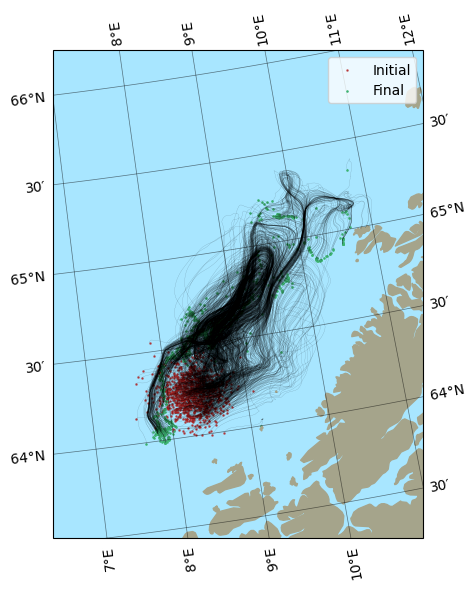

In [75]:
#Plot på kartet
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_facecolor('#a8e6ff')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#a5a48b'))
# ax.coastlines(resolution='10m')

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

ax.scatter(X[0,:], X[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.5, color='black')
ax.scatter(E[0,:,-1], E[1,:,-1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')



# Make outline a bit larger
ax.set_extent((7, 11, 63.5, 66))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

Kommenter plott

Tekst

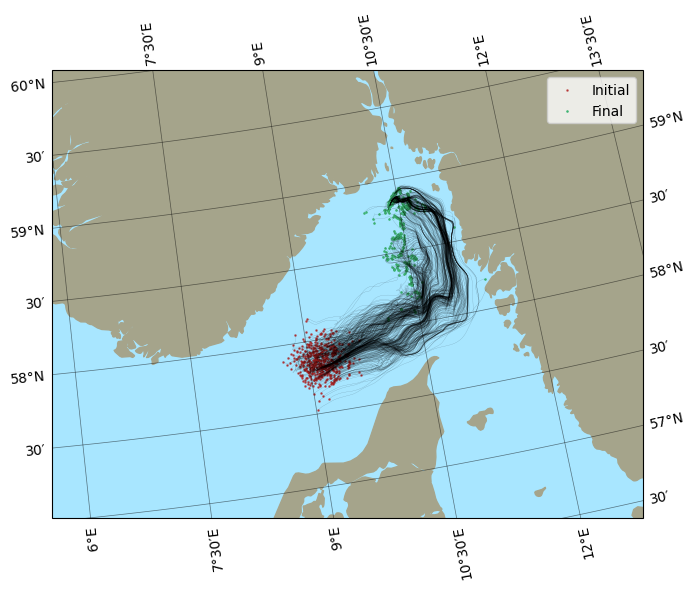

In [77]:
#kattegat

# create some positions
mean_x = 190000
mean_y = 110000
standard_dev = 10000

Np = 500
X1 = np.zeros((2, Np))
X1[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X1[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E1 = np.zeros((2,Np))

E1 = Heun(3600,3600*5*24,X1, f)

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_facecolor('#a8e6ff')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#a5a48b'))
# ax.coastlines(resolution='50m')

ax.scatter(X1[0,:], X1[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)
for i in range(Np):
    ax.plot(E1[0,i,:],E1[1,i,:], transform=npstere, lw=0.1, alpha=0.5, color='black')
ax.scatter(E1[0,:,-1], E1[1,:,-1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')



# Make outline a bit larger
ax.set_extent((6, 13, 59.5, 57))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

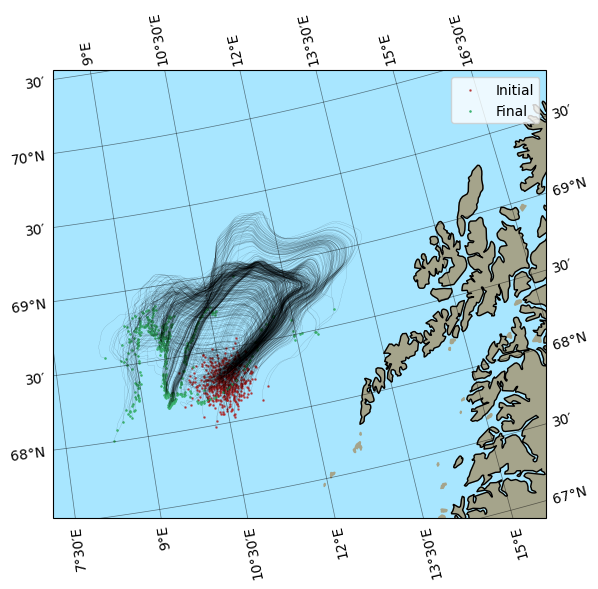

In [78]:
#bodø

# create some positions
mean_x = 1220000
mean_y = 620000
standard_dev = 10000

Np = 500
X2 = np.zeros((2, Np))
X2[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X2[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E2 = np.zeros((2,Np))

E2 = Heun(3600,3600*5*24,X2, f)

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_facecolor('#a8e6ff')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#a5a48b'))
ax.coastlines(resolution='10m')

ax.scatter(X2[0,:], X2[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)
for i in range(Np):
    ax.plot(E2[0,i,:],E2[1,i,:], transform=npstere, lw=0.1, alpha=0.5, color='black')
ax.scatter(E2[0,:,-1], E2[1,:,-1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')



# Make outline a bit larger
ax.set_extent((8, 16, 67.5, 70))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

In [ ]:
#bodø

# create some positions
mean_x = 1915000
mean_y = 300000
standard_dev = 10000

Np = 500
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = Heun(3600,3600*5*24,X, f)

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_facecolor('#a8e6ff')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#a5a48b'))
ax.coastlines(resolution='10m')

ax.scatter(X[0,:], X[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.5, color='black')
ax.scatter(E[0,:,-1], E[1,:,-1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')



# Make outline a bit larger
ax.set_extent((25, 30, 70, 72.2))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

3) Until now, the model has not taken into account that particles might end up hitting land. The function `on_land` from the `Interpolate` class will be used to modify the `Heun` method. The modified implementation, `HeunWithStop`, is given below.

In [ ]:
def HeunWithStop(h, tEnd, initPos, f):
    tList = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(tList)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(tList)):
        coordI = coordArr[:,:,i-1]
        ti = tList[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = np.where(f.on_land(coordArr[:,:,i-1]),coordI,coordI +h/2*(k1 + k2))

    return coordArr



3a) The modified method provides the opportunity to examine how many particles strand, as well as where and when they strand. To look into this, we place particles at a point off the coast of Western Norway, and simulate their movements.

In [ ]:
mean_x = 250000
mean_y = 460000
standard_dev = 10000


Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = HeunWithStop(3600,3600*3*24,X, f)

In [ ]:
#Plot på kartet
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_facecolor('#a8e6ff')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#a5a48b'))
ax.coastlines(resolution='10m')

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

ax.scatter(X[0,:], X[1,:], s=1, transform=npstere, label='Initial', color='firebrick')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.2)

final_pos = E[:,:,-1]
afloat = final_pos[:,f.on_land(final_pos)==False]
stranded = final_pos[:,f.on_land(final_pos)==True]

print(afloat.shape)

ax.scatter(afloat[0,:], afloat[1,:], s=1, transform=npstere, label='afloat', color='mediumseagreen')
ax.scatter(stranded[0,:], stranded[1,:], s=1, transform=npstere, label='on land', color='darkorange')





# Make outline a bit larger
# ax.set_extent((7, 11, 63.5, 65))
#ax.set_extent((2, 7, 60, 61.5))
ax.set_extent((3, 6, 59.25, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

Figure n: Plot showing the movement of particles over 3 days, taking into account stranding of particles. The green dots indicate stranded particles, while the orange dots indicate particles still afloat

In [ ]:
num_stranded = np.zeros(E.shape[-1])
for i in range(E.shape[-1]):
    num_stranded[i] = np.count_nonzero(f.on_land(E[:,:,i]))

plt.plot(num_stranded)

Figure n: Plot showing the number of stranded particles as a function of time. 

We see that, as intuition would suggest, the longer the particles move, the more likely they are to hit land.

3b)

In [ ]:
# Try different windage factors and how they affect results, for example
# percentage of stranded after three days as function of f_w.

f_w_arr = np.linspace(0, 0.15, 10)
stranded_arr = np.zeros(f_w_arr.shape)
for i, f_w in enumerate(f_w_arr):
    g = Interpolator(dataset = d, fw = f_w)
    E = HeunWithStop(3600,3600*3*24,X, g)
    num_stranded = np.count_nonzero(f.on_land(E[:,:,-1]))
    
    stranded_arr[i] = num_stranded

plt.plot(f_w_arr, stranded_arr)
plt.xlabel('Windage factor')
plt.ylabel('Stranded particles after 3 days')
plt.tight_layout()

Oppsummering

Kilde